<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/Laplace_Around_MAP_External_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

In [52]:
generator_path = './gdrive/My Drive/MPM/modules/vae1/vae_1/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/vae1/vae_1/encoder'
!ls 

data  gdrive  sample_data


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [241]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 1
hidden_size = 10
num_comp    = 3

sample_size_z = tf.placeholder_with_default(10,shape=[])
sample_size_x = tf.placeholder_with_default(10,shape=[])
lr            = tf.placeholder_with_default(0.001,shape=[])
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)


generator = hub.Module(generator_path)
encoder   = hub.Module(encoder_path)

# Define latent space prior
prior = tfd.MultivariateNormalDiag(loc=tf.zeros([hidden_size]),scale_identity_multiplier=1.0)
# get some masked data
x_corr            = tf.placeholder(shape=[batch_size,784,1], dtype=tf.float32)
mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])
m_data            = tf.boolean_mask(x_corr, mymask, axis=1)

encoded_data      = encoder(tf.expand_dims(tf.reshape(x_corr,[-1,28,28]),-1))
mu, sigma         = tf.split(encoded_data, 2, axis=-1)
naive_sims        = tfd.Independent(tfd.Bernoulli(logits=generator(mu))).sample(sample_size_x)
naive_mean        = tfd.Independent(tfd.Bernoulli(logits=generator(mu))).mean()

######## find the MAP by minimization
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size,hidden_size]),shape=[batch_size,hidden_size])

MAP                  = tf.Variable(MAP_ini)
MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))
genMAP               = tf.reshape(generator(MAP),[batch_size,784,1])
el2o_logits          = tf.boolean_mask(genMAP, mymask, axis=1)
data_likelihood_el2o = tfd.Independent(tfd.Bernoulli(logits=el2o_logits))
posterior_corr_MAP   = prior.log_prob(MAP)+data_likelihood_el2o.log_prob(m_data)
loss                 = -tf.reduce_mean(posterior_corr_MAP)

opt_op2 = optimizer.minimize(loss, var_list=[MAP])

MAP_sims           = tfd.Independent(tfd.Bernoulli(logits=generator(MAP))).sample(sample_size_x)
MAP_mean           = tfd.Independent(tfd.Bernoulli(logits=generator(MAP))).mean()

## get approximate posterior Laplace approximation

ini_val  = np.ones((batch_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)

with tf.variable_scope("corrupted/approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size,hidden_size)), dtype=np.float32)
  sigma_new_t = tf.constant(ini_val)
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus))
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update2          = tf.stop_gradient(mu_new.assign(MAP))

hess             = tf.hessians(-posterior_corr_MAP,MAP)

hess             = tf.gather(hess, 0)

hess2            = tf.reduce_sum(hess, axis = 2 )

sigma_new        = tf.linalg.inv(hess2)

update3          = sigma_new_t2.assign(tf.linalg.cholesky(sigma_new))

#compute negative log prob of approximate posterior at 
lapl_log_prob_MAP = approx_posterior_laplace.log_prob(MAP)
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())
log_det           = tf.linalg.logdet(approx_posterior_laplace.covariance())

new_z_samples    = tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size])

new_x_mean       = tf.reshape(tfd.Independent(tfd.Bernoulli(logits=generator(new_z_samples))).mean(),[sample_size_z,batch_size,784])

# construct a GMM approximation from different minima

with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((batch_size,num_comp,hidden_size)), dtype=np.float32)
  ini_val2    = np.ones((batch_size,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
  sigma_gmm   = tf.constant(ini_val2)
  sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

mu_est        = tf.placeholder_with_default(tf.zeros([batch_size,num_comp,hidden_size]),shape=[batch_size,num_comp,hidden_size])
sigma_est     = tf.placeholder_with_default(tf.ones([batch_size,num_comp,hidden_size, hidden_size]),shape=[batch_size,num_comp,hidden_size, hidden_size])
w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_a      = w_gmm.assign(w_est)
update_b      = mu_gmm.assign(mu_est)
update_c      = sigma_gmmt.assign(sigma_est)

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

gmm_sample_z  = tf.reshape(gmm.sample(sample_size_z),[-1,hidden_size])
gmm_sample_x  = tf.reshape(tfd.Independent(tfd.Bernoulli(logits=generator(gmm_sample_z))).mean(),[sample_size_z,batch_size,784])


# ### for comparison: get minimize elbo for corrupted data

with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size,hidden_size)), dtype=np.float32)

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')
zz_               = approx_posterior_elbo.sample()
elbo_mean         = approx_posterior_elbo.mean()
kl_divergence2    = tfd.kl_divergence(approx_posterior_elbo, prior) 
genz              = tf.reshape(generator(zz_),[batch_size,784,1])
elbo_liklogits    = tf.boolean_mask(genz, mymask, axis=1)
data_likelihood2  = tfd.Independent(tfd.Bernoulli(logits=elbo_liklogits))
elbo2             = -tf.reduce_mean(data_likelihood2.log_prob(m_data)- kl_divergence2,axis=0)

opt_op_elbo2      = optimizer.minimize(elbo2,var_list=[mu_elbo,sigma_elbo])

posterior_corr_elbo= prior.log_prob(mu_elbo)+data_likelihood2.log_prob(m_data)

z_samples_elbo    = tf.reshape(approx_posterior_elbo.sample(sample_size_z),[-1,hidden_size])
x_mean_elbo       = tf.reshape(tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_elbo))).mean(),[sample_size_z,batch_size,784])


#var_new           = tf.math.sqrt(tf.matrix_diag_part(sigma_new))
#var_mean          = tfd.Independent(tfd.Bernoulli(logits=generator(var_new))).mean()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0425 23:37:37.267574 140369430304640 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0425 23:37:37.294993 140369430304640 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0425 23:37:37.341738 140369430304640 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0425 23:37:37.368388 140369430304640 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0425 23:37:37.645521 140369430304640 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0425 23:37:37.690323 140369430304640 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0425 23:37:38.281981 140369430304640 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0425 23:37:38.469624 140369430304640 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0425 23:37:38.579041 140369430304640 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0425 23:37:38.942054 140369430304640 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
inc = 6
x_truth = x_test[inc:batch_size+inc]

<Figure size 360x360 with 0 Axes>

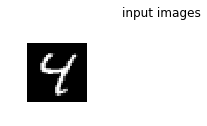

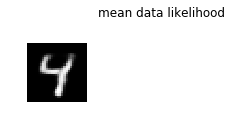

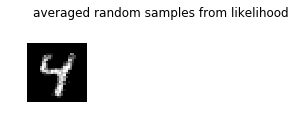

In [244]:
inim, res, s = sess.run([x_corr,naive_mean,naive_sims], feed_dict={x_corr: np.expand_dims(x_truth,-1)})
figure(figsize=(5,5))

    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(res[i,:,:,0],cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('averaged random samples from likelihood')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:,:,0],axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

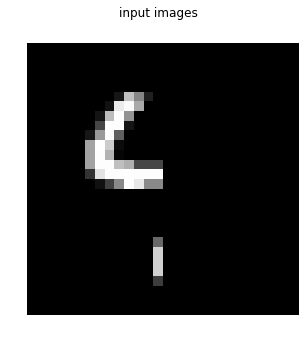

In [245]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[0:28,14:28]=0.
mask = mask.reshape((28*28))

masked_data = np.expand_dims(x_test[inc:batch_size+inc]*[mask],-1)

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    if batch_size<16:
      subplot(1,batch_size,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')

<Figure size 360x360 with 0 Axes>

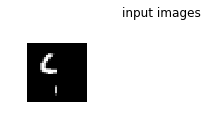

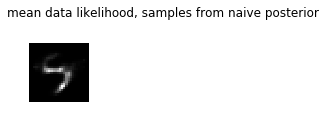

In [246]:
inim, res = sess.run([x_corr,naive_mean],feed_dict={x_corr: masked_data, mymask:mask})


figure(figsize=(5,5))

    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood, samples from naive posterior')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(res[i,:,:,0],cmap='gray',vmin=0); #colorbar()
    axis('off')



In [247]:
posterior2_loss=[]
ini = np.zeros((batch_size,hidden_size), dtype=np.float)
sess.run(MAP_reset,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:ini})

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [248]:
lrate=1e-1
for ii in range(300):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-3
for ii in range(800):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-5
for ii in range(800):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)

158.44145
45.746445
45.299145
45.29883
45.29812
45.298157
45.29815
45.298065
45.29814
45.298218
45.29812
45.29813
45.29805
45.29805
45.29805
45.29805
45.29805
45.29805
45.29805


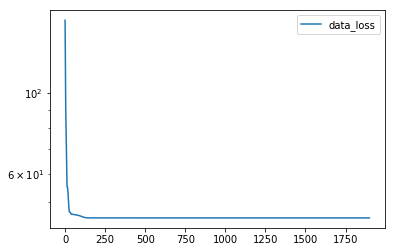

In [249]:
plot(posterior2_loss,label='data_loss')
legend()
yscale('log')

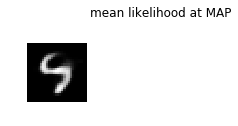

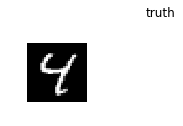

In [250]:
xrecons= sess.run(MAP_mean, feed_dict={x_corr: masked_data, mymask: mask})
xrecons.shape
    

figure(figsize=(5,5))
suptitle('mean likelihood at MAP')
for i in range(min(batch_size,16)):
#     if batch_size<16:
#       subplot(1,batch_size,i+1)
#       imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
#       axis('off')
#     else:
    subplot(4,4,i+1)
    imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
      
figure(figsize=(5,5))
suptitle('truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
_=sess.run(update2,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

In [0]:
_=sess.run(update3,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

(64, 1, 784)


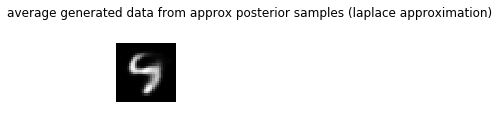

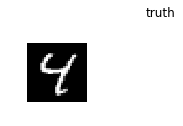

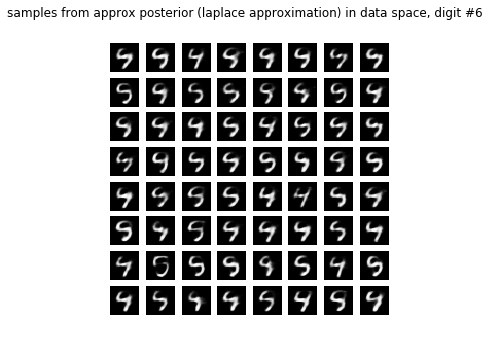

In [253]:
xrecons3 = sess.run(new_x_mean, feed_dict={x_corr: masked_data, sample_size_z:64 , mymask: mask})
print(xrecons3.shape)
# xrecons4 = sess.run(var_mean, feed_dict={x_corr: masked_data, sample_size:64, mymask: mask})
# print(xrecons3.shape)

figure(figsize=(5,5))
suptitle('average generated data from approx posterior samples (laplace approximation)')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons3[:,i,:],axis=(0)).reshape((28,28)),cmap='gray',vmin=0); 
    axis('off')
      
figure(figsize=(5,5))
suptitle('truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('samples from approx posterior (laplace approximation) in data space, digit #%d'%inc)
for jj in range(64):   
  subplot(8,8,jj+1)
  imshow(xrecons3[jj,0].reshape((28,28)),cmap='gray',vmin=0); 
  axis('off')
 
      

In [254]:
minima=[]
min_loss=[]
n_samples=20
for jj in range(n_samples):
  print(jj)
  ini = np.random.randn(batch_size,hidden_size)*5
  sess.run(MAP_reset,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:ini})
  for lrate,num in zip([1e-1,1e-2, 1e-3, 1e-5],[300,400,1000,1000]):
    for ii in range(num):
      _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  minima+=[sess.run(MAP,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:ini})]
  min_loss+=[ll]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


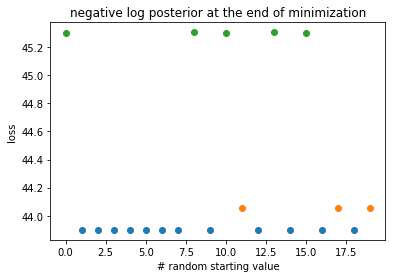

In [256]:
min_loss = np.asarray(min_loss)
index1 = np.where(min_loss<44)
# index3 = np.where((min_loss>60)*(min_loss<90))
index3 = np.where(min_loss>45)
index2 = np.where((min_loss>44)*(min_loss<44.2))
x = np.arange(n_samples)
plt.figure()
plt.title('negative log posterior at the end of minimization')
plt.plot(x[index1],min_loss[index1], ls='', marker='o')
plt.plot(x[index2],min_loss[index2], ls='', marker='o')
plt.plot(x[index3],min_loss[index3], ls='', marker='o')
plt.plot(x[index4],min_loss[index4], ls='', marker='o')
#plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# random starting value')
plt.ylabel('loss')
plt.show()

W0425 23:41:01.395235 140369430304640 legend.py:1289] No handles with labels found to put in legend.


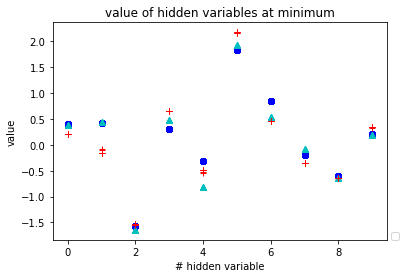

In [257]:
minima = np.asarray(minima)
plt.figure()
plt.title('value of hidden variables at minimum')
for index, color, m in zip([index1, index2, index3],['b','c','r','coral'], ['o','^','+','*']):
  for ii in index[0]:
    plt.plot(np.arange(hidden_size),minima[ii,0,:], ls='', marker=m, color=color)
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

assuming there are four distinct minima in this case

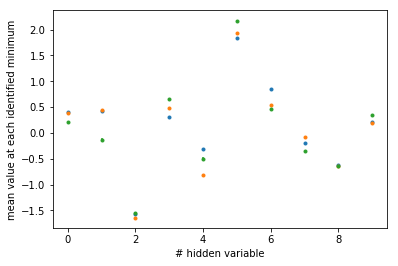

In [258]:
mus = []
std_mus = []
for index in [index1, index2, index3]:
  mus+=[np.mean(minima[index], axis=0)]
  std_mus+=[np.std(minima[index], axis=0)]

mus    =np.asarray(mus)
std_mus=np.asarray(std_mus)
plt.figure()
for ii in range(num_comp):
  plt.errorbar(np.arange(hidden_size),mus[ii][0], yerr=std_mus[ii][0], ls='', marker='.')
plt.xlabel('# hidden variable')
plt.ylabel('mean value at each identified minimum')
plt.show()

get covariances at these three minima to build Gaussian mixture model

[[ 0.40390995  0.4160454  -1.5684832   0.30107045 -0.30964944  1.8302697
   0.85153013 -0.19617684 -0.61166984  0.20230508]]
[-43.89909] [6.176446]
[[ 0.37605986  0.4391946  -1.6448692   0.48621526 -0.8209117   1.937256
   0.5380141  -0.0783013  -0.64512414  0.19004709]]
[-44.058075] [6.1381893]
[[ 0.21612899 -0.1290344  -1.5402281   0.6559146  -0.50232184  2.1725245
   0.4639402  -0.35683113 -0.636465    0.3449269 ]]
[-45.305782] [4.9137125]
[[1.7884283e-22]
 [1.5850340e-22]
 [1.5486416e-22]]
[0.36334634 0.3220237  0.31463003]


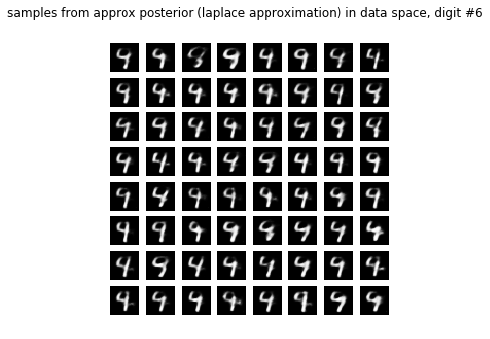

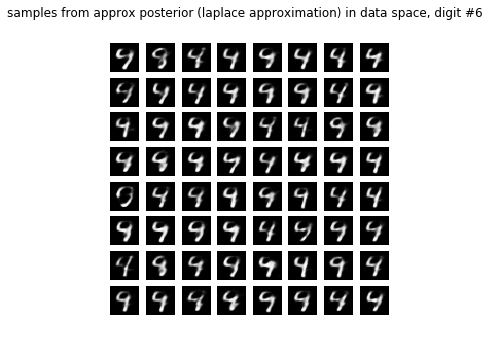

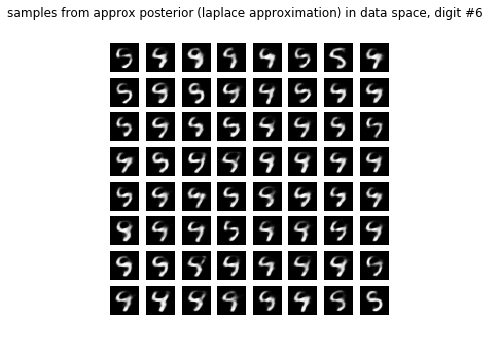

In [267]:
mu_=[]
sigma_=[]
w_tilde=[]
diag=[]
for ii in range(num_comp):
  print(sess.run(MAP_reset,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:mus[ii]}))
  mu_+=[sess.run(update2,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  sigma_+=[sess.run(update3,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  xrecons3 = sess.run(new_x_mean, feed_dict={x_corr: masked_data, sample_size_z:64 , mymask: mask})
  figure(figsize=(5,5))
  suptitle('samples from approx posterior (laplace approximation) in data space, digit #%d'%inc)
  for jj in range(64):   
    subplot(8,8,jj+1)
    imshow(xrecons3[jj,0].reshape((28,28)),cmap='gray',vmin=0); 
    axis('off')
  diag+=[sess.run(lapl_variance_MAP,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  logdet_=sess.run(log_det,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  logprob_lap, logprob = sess.run([lapl_log_prob_MAP,posterior_corr_MAP],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  w_tilde+=[np.exp(0.5*logdet_+logprob)]
  #same as
  #w_tilde+=[np.exp(-logprob_lap+logprob)]
  print(logprob, logprob_lap)
mu_    = np.asarray(mu_)
sigma_ = np.asarray(sigma_)

w_tilde= np.asarray(w_tilde)
print(w_tilde)

A = 1./np.sum(w_tilde)

w = w_tilde*A
w = np.squeeze(w)
print(w)


In [261]:
print(logdet_)

[array([-30.731663], dtype=float32), array([-30.65515], dtype=float32), array([-28.206196], dtype=float32)]


In [229]:
diag=np.asarray(diag)
diag.shape

(3, 1, 10)

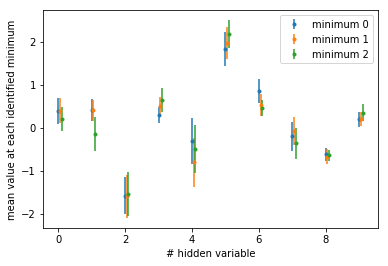

In [235]:
mus = []
std_mus = []
for index in [index1, index2, index3]:
  mus+=[np.mean(minima[index], axis=0)]
  std_mus+=[np.std(minima[index], axis=0)]

mus    =np.asarray(mus)
std_mus=np.asarray(std_mus)
plt.figure()
for ii in range(num_comp):
  plt.errorbar(np.arange(hidden_size)+ii*0.05,mus[ii][0], yerr=np.sqrt(diag[ii][0]), ls='', marker='.',label='minimum %d'%ii)
plt.xlabel('# hidden variable')
plt.ylabel('mean value at each identified minimum')
plt.legend()
plt.show()

In [236]:
w=[]
#choosing weights from how often I land in this minimum?
for index in [index1, index2, index3]:
  w+=[len(index[0])/n_samples]
w=np.asarray(w)
print(sum(w),w)


1.0 [0.45 0.3  0.25]


In [0]:
sigma_=sigma_.reshape(batch_size,num_comp,hidden_size,hidden_size)
mu_=mu_.reshape(batch_size,num_comp,hidden_size)

In [0]:
_= sess.run(gmm_sample_x,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })
_= sess.run(update_a,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_b,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_c,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })

In [0]:
#sess.run(print(gmm.parameters),feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })

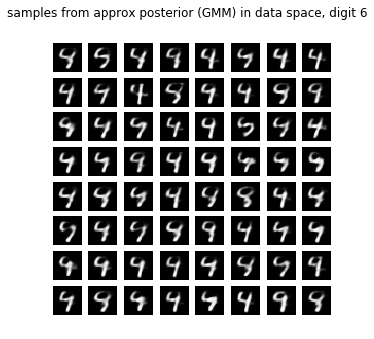

In [239]:
x_recons = sess.run(gmm_sample_x,feed_dict={x_corr: masked_data, sample_size_z:64 , mymask: mask})

num = 6
figure(figsize=(5,5))
suptitle('samples from approx posterior (GMM) in data space, digit %d'%num)
for jj in range(64):   
  subplot(8,8,jj+1)
  imshow(x_recons[jj,0,:].reshape((28,28)),cmap='gray',vmin=0); 
  axis('off')

In [0]:
posterior3_loss=[]

In [117]:
lrate=1e-2
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior3_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-4
for ii in range(1000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior3_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-8
for ii in range(1000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior3_loss.append(ll)
  if ii%100==0:
    print(ll)

125.43983
53.972427
51.095417
52.852158
52.220303
51.745453
59.79688
55.41687
48.886444
50.290237
50.705467
47.86161
51.23502
48.224148
52.202114
50.274364
53.394047
55.747158
57.70546
54.788666
51.10123
54.316017
55.443016
50.435104
54.1687
48.934147
51.920067
49.782227
51.653595
46.90789
53.275257
49.099495
48.620316
57.055885
50.92048
50.751114
49.366768
51.398243
49.64446
50.181084


In [118]:
sess.run([tf.reduce_mean(posterior_corr_elbo),posterior_corr_MAP],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

[-48.52991, array([-45.299267], dtype=float32)]

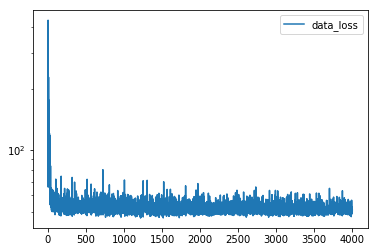

In [119]:
plot(posterior3_loss,label='data_loss')
legend()
yscale('log')

(64, 1, 784)


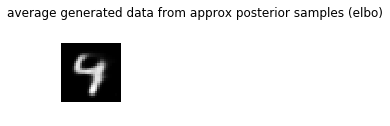

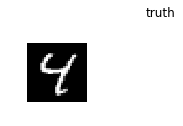

In [120]:
xrecons3 = sess.run(x_mean_elbo, feed_dict={x_corr: masked_data, sample_size_z:64 , mymask: mask})
print(xrecons3.shape)
# xrecons4 = sess.run(var_mean, feed_dict={x_corr: masked_data, sample_size:64, mymask: mask})
# print(xrecons3.shape)

figure(figsize=(5,5))
suptitle('average generated data from approx posterior samples (elbo)')
for i in range(min(batch_size,16)):
      subplot(4,4,i+1)
      imshow(np.mean(xrecons3[:,i,:],axis=(0)).reshape((28,28)),cmap='gray',vmin=0); 
      axis('off')
      
figure(figsize=(5,5))
suptitle('truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')